# Augmenting Data to Treat Imbalanced Data using CGAN

In [3]:
import pandas as pd

data = pd.read_csv("../RainData/IndianWeatherDataRepo/IndWeatherDataset.csv")
data = data[data.region=="Uttar Pradesh"]
cols = ["last_updated_epoch", "temperature_celsius", "humidity", "wind_kph", "wind_degree", "pressure_mb", "precip_mm", "gust_kph", "condition_text"]
data = data[cols]

# data["Date"] = pd.to_datetime(data["last_updated_epoch"], unit="s").dt.date
# data.sort_values(by="last_updated_epoch", inplace=True)
data.drop(columns=["last_updated_epoch"], inplace=True)

# data.index = data["Date"]
# data.sort_index(inplace=True)

display(data.head())
display(data.info())
data.describe()

,temperature_celsius,humidity,wind_kph,wind_degree,pressure_mb,precip_mm,gust_kph,condition_text
21,28.1,65,17.6,280,1007.0,0.3,25.2,Patchy rain possible
57,30.8,57,13.0,282,1005.0,0.0,16.9,Partly cloudy
72,32.4,49,17.3,290,1006.0,0.1,20.5,Patchy rain possible
83,31.0,66,15.1,290,1004.0,0.0,17.3,Mist
134,28.0,64,14.8,279,1007.0,0.0,18.7,Sunny


<class 'pandas.core.frame.DataFrame'>
Index: 13171 entries, 21 to 118293
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   temperature_celsius  13171 non-null  float64
 1   humidity             13171 non-null  int64  
 2   wind_kph             13171 non-null  float64
 3   wind_degree          13171 non-null  int64  
 4   pressure_mb          13171 non-null  float64
 5   precip_mm            13171 non-null  float64
 6   gust_kph             13171 non-null  float64
 7   condition_text       13171 non-null  object 
dtypes: float64(5), int64(2), object(1)
memory usage: 926.1+ KB


None

,temperature_celsius,humidity,wind_kph,wind_degree,pressure_mb,precip_mm,gust_kph
count,13171.000000,13171.000000,13171.000000,13171.000000,13171.000000,13171.000000,13171.000000
mean,19.522375,54.622884,7.658181,191.672994,1012.527219,0.045780,16.093425
std,5.784911,22.404377,3.608764,123.486527,5.231751,0.300082,7.314016
min,5.000000,9.000000,3.600000,1.000000,997.000000,0.000000,0.000000
25%,14.700000,39.000000,4.700000,69.000000,1009.000000,0.000000,10.600000
50%,19.400000,51.000000,6.800000,231.000000,1014.000000,0.000000,15.100000
75%,24.200000,71.000000,9.700000,308.000000,1017.000000,0.000000,20.900000
max,36.100000,100.000000,33.800000,360.000000,1022.000000,7.700000,71.100000


In [4]:
data.condition_text.value_counts()

condition_text
Clear                                     6354
Clear                                     2594
Mist                                      1599
Partly cloudy                              743
Patchy rain possible                       384
Fog                                        321
Partly Cloudy                              278
Light rain shower                          235
Overcast                                   125
Patchy rain nearby                         113
Cloudy                                      90
Sunny                                       62
Overcast                                    55
Moderate or heavy rain shower               39
Moderate or heavy rain with thunder         34
Light rain                                  31
Cloudy                                      23
Light drizzle                               15
Patchy light drizzle                        15
Partly Cloudy                               15
Thundery outbreaks possible                 1

In [5]:
data["condition_text"] = data["condition_text"].apply(lambda x: x.lower().strip())
data["condition_text"].replace("partly cloudy", "cloudy", inplace=True)
data["condition_text"].replace("overcast", "cloudy", inplace=True)

data["condition_text"].replace("patchy rain possible", "patchy rain", inplace=True)
data["condition_text"].replace("patchy rain nearby", "patchy rain", inplace=True)

data["condition_text"].replace("patchy light drizzle", "patchy light rain", inplace=True)
data["condition_text"].replace("patchy light rain", "patchy light rain", inplace=True)

data["condition_text"].replace("patchy light rain with thunder", "patchy light rain, thunder", inplace=True)
data["condition_text"].replace("patchy light rain in area with thunder", "patchy light rain, thunder", inplace=True)

data["condition_text"].replace("light drizzle", "light rain", inplace=True)
data["condition_text"].replace("light rain shower", "light rain", inplace=True)

data["condition_text"].replace("light rain with thunder", "light rain, thunder", inplace=True)
data["condition_text"].replace("light rain in area with thunder", "light rain, thunder", inplace=True)

data["condition_text"].replace("moderate rain at times", "moderate rain", inplace=True)

data["condition_text"].replace("heavy rain at times", "heavy rain", inplace=True)
data["condition_text"].replace("moderate or heavy rain shower", "heavy rain", inplace=True)
data["condition_text"].replace("torrential rain shower", "heavy rain", inplace=True)

data["condition_text"].replace("moderate or heavy rain with thunder", "heavy rain, thunder", inplace=True)

data["condition_text"].replace("thundery outbreaks possible", "thunderstorm", inplace=True)
data["condition_text"].replace("thundery outbreaks in nearby", "thunderstorm", inplace=True)

data.condition_text.value_counts()

condition_text
clear                         8948
mist                          1599
cloudy                        1329
patchy rain                    497
fog                            321
light rain                     281
sunny                           62
heavy rain                      40
heavy rain, thunder             34
patchy light rain               27
thunderstorm                    15
patchy light rain, thunder      12
moderate rain                    6
Name: count, dtype: int64

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler, LabelEncoder

In [7]:
features = data[['temperature_celsius', 'humidity', 'wind_kph', "wind_degree", 'pressure_mb', 'precip_mm', 'gust_kph']]
labels = data['condition_text']

scaler = MinMaxScaler()
features_scaled = scaler.fit_transform(features)

condition_encoder = LabelEncoder()
conditions_encoded = condition_encoder.fit_transform(labels)

features_tensor = torch.tensor(features_scaled, dtype=torch.float32)
conditions_tensor = torch.tensor(conditions_encoded, dtype=torch.long)

In [8]:
class Generator(nn.Module):
    def __init__(self, input_dim, label_dim, output_dim):
        super(Generator, self).__init__()
        self.label_embedding = nn.Embedding(label_dim, label_dim)
        self.model = nn.Sequential(
            nn.Linear(input_dim + label_dim, 128),
            nn.ReLU(),
            nn.Linear(128, output_dim),
            nn.Sigmoid()
        )

    def forward(self, noise, labels):
        label_input = self.label_embedding(labels)
        gen_input = torch.cat((noise, label_input), -1)
        return self.model(gen_input)

class Discriminator(nn.Module):
    def __init__(self, input_dim, label_dim):
        super(Discriminator, self).__init__()
        self.label_embedding = nn.Embedding(label_dim, label_dim)
        self.model = nn.Sequential(
            nn.Linear(input_dim + label_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )

    def forward(self, data, labels):
        label_input = self.label_embedding(labels)
        disc_input = torch.cat((data, label_input), -1)
        return self.model(disc_input)

In [9]:
input_dim = features_tensor.shape[1]
condition_dim = len(condition_encoder.classes_)
latent_dim = 100
batch_size = 64
epochs = 10000

# Initialize models
generator = Generator(latent_dim, condition_dim, input_dim)
discriminator = Discriminator(input_dim, condition_dim)

In [10]:
criterion = nn.BCELoss()
optimizer_G = optim.Adam(generator.parameters(), lr=0.0002)
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0002)

In [11]:
best_loss_G = float('inf')
patience = 10
trigger_times = 0

for epoch in range(epochs):
    # Train Discriminator
    optimizer_D.zero_grad()
    real_conditions = torch.ones(batch_size, 1)
    fake_conditions = torch.zeros(batch_size, 1)
    
    # Real data
    idx = torch.randint(0, features_tensor.size(0), (batch_size,))
    real_data = features_tensor[idx]
    conditions_real = conditions_tensor[idx]
    output_real = discriminator(real_data, conditions_real)
    loss_real = criterion(output_real, real_conditions)
    
    # Fake data
    noise = torch.randn(batch_size, latent_dim)
    conditions_fake = torch.randint(0, condition_dim, (batch_size,))
    fake_data = generator(noise, conditions_fake)
    output_fake = discriminator(fake_data.detach(), conditions_fake)
    loss_fake = criterion(output_fake, fake_conditions)
    
    # Total loss and optimization
    loss_D = loss_real + loss_fake
    loss_D.backward()
    optimizer_D.step()
    
    # Train Generator
    optimizer_G.zero_grad()
    output_fake = discriminator(fake_data, conditions_fake)
    loss_G = criterion(output_fake, real_conditions)
    loss_G.backward()
    optimizer_G.step()
    
    # Print progress
    if epoch % 1000 == 0:
        print(f'Epoch [{epoch}/{epochs}]  Loss D: {loss_D.item()}, Loss G: {loss_G.item()}')
    
    # Early stopping
    if loss_G < best_loss_G:
        best_loss_G = loss_G
        trigger_times = 0
    else:
        trigger_times += 1
        if trigger_times >= patience:
            print(f'Early stopping at epoch  [{epoch}/{epochs}]  Loss D: {loss_D.item()}, Loss G: {loss_G.item()}')
            break

Epoch [0/10000]  Loss D: 1.3822236061096191, Loss G: 0.6521190404891968
Early stopping at epoch  [20/10000]  Loss D: 1.3022799491882324, Loss G: 0.6571985483169556


In [14]:
from collections import Counter
import numpy as np

# Determine the number of samples for each class
class_counts = Counter(conditions_tensor.numpy())
max_count = max(class_counts.values())

# Generate synthetic data to balance the dataset
synthetic_features = []
synthetic_labels = []

for label, count in class_counts.items():
    num_samples_to_generate = max_count - count
    noise = torch.randn(num_samples_to_generate, latent_dim)
    labels_new = torch.tensor([label] * num_samples_to_generate, dtype=torch.long)  # Explicitly set dtype to long
    synthetic_data = generator(noise, labels_new).detach().numpy()
    
    synthetic_features.append(synthetic_data)
    synthetic_labels.extend([label] * num_samples_to_generate)

# Concatenate the synthetic data with the original data
synthetic_features = np.vstack(synthetic_features)
synthetic_labels = np.array(synthetic_labels, dtype=np.int64)  # Explicitly set dtype to int64

balanced_features = np.vstack((features_scaled, synthetic_features))
balanced_labels = np.hstack((conditions_encoded, synthetic_labels))

# Convert to tensors
balanced_features_tensor = torch.tensor(balanced_features, dtype=torch.float32)
balanced_labels_tensor = torch.tensor(balanced_labels, dtype=torch.long)

C:\Users\navee\AppData\Local\Temp\ipykernel_7468\3781372980.py:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[7].set_xticklabels(axes[7].get_xticklabels(), rotation=45, ha='right')


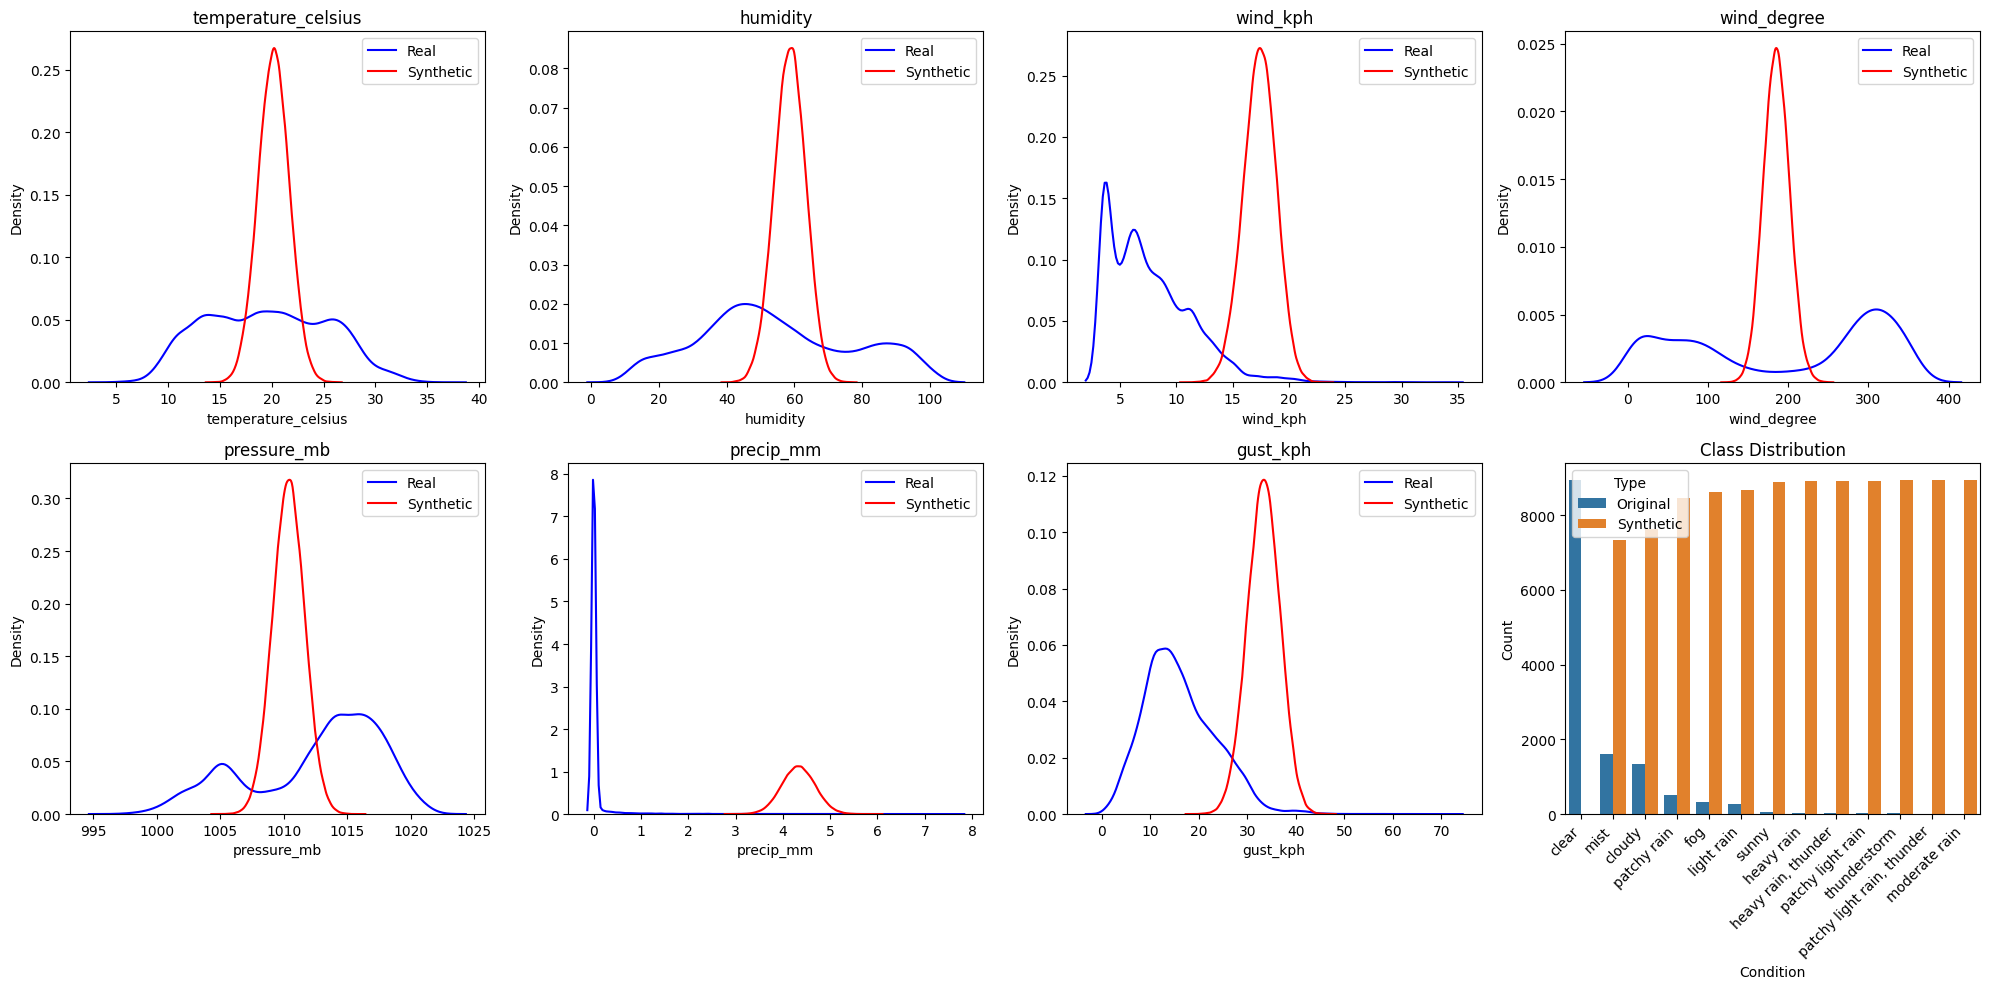

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

ddp = features

# Plotting the distribution of real vs synthetic data for each feature
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.ravel()

feature_names = ['temperature_celsius', 'humidity', 'wind_kph', 'wind_degree', 
                'pressure_mb', 'precip_mm', 'gust_kph']

for i, feature in enumerate(feature_names):
    # Real data distribution
    sns.kdeplot(data=ddp[feature], ax=axes[i], label='Real', color='blue')
    
    # Synthetic data distribution (need to inverse transform the scaled data)
    synthetic_feature = scaler.inverse_transform(synthetic_features)[:, i]
    sns.kdeplot(data=synthetic_feature, ax=axes[i], label='Synthetic', color='red')
    
    axes[i].set_title(feature)
    axes[i].legend()

# Plot class distribution
original_counts = pd.Series(condition_encoder.inverse_transform(conditions_encoded)).value_counts()
synthetic_counts = pd.Series(condition_encoder.inverse_transform(synthetic_labels.astype(int))).value_counts()

original_df = pd.DataFrame({'Condition': original_counts.index, 'Count': original_counts.values, 'Type': 'Original'})
synthetic_df = pd.DataFrame({'Condition': synthetic_counts.index, 'Count': synthetic_counts.values, 'Type': 'Synthetic'})
combined_df = pd.concat([original_df, synthetic_df])

sns.barplot(data=combined_df, x='Condition', y='Count', hue='Type', ax=axes[7])
axes[7].set_xticklabels(axes[7].get_xticklabels(), rotation=45, ha='right')
axes[7].set_title('Class Distribution')

plt.tight_layout()


In [12]:
# Convert the balanced data to a DataFrame
balanced_data = np.hstack((balanced_features, balanced_labels.reshape(-1, 1)))
columns = ['temperature_celsius', 'humidity', 'wind_kph', 'wind_degree', 'pressure_mb', 'precip_mm', 'gust_kph', 'condition_text']
balanced_df = pd.DataFrame(balanced_data, columns=columns)

# Decode the condition_text labels
balanced_df['condition_text'] = condition_encoder.inverse_transform(balanced_df['condition_text'].astype(int))

# Write the balanced DataFrame to a CSV file
balanced_df.to_csv('balanced_weather_data.csv', index=False)

In [ ]:
# noise = torch.randn(number_of_samples, latent_dim)
# labels_new = torch.tensor([desired_class_label] * number_of_samples)
# synthetic_data = generator(noise, labels_new).detach().numpy()

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

ddp = pd.read_csv("CGAN_AugIndWeatherDataset.csv")
ddp.head()

,temperature_celsius,humidity,wind_kph,wind_degree,pressure_mb,precip_mm,gust_kph,condition_text
0,28.1,65.0,17.6,280.0,1007.0,0.3,25.2,patchy rain
1,30.8,57.0,13.0,282.0,1005.0,0.0,16.9,cloudy
2,32.4,49.0,17.3,290.0,1006.0,0.1,20.5,patchy rain
3,31.0,66.0,15.1,290.0,1004.0,0.0,17.3,mist
4,28.0,64.0,14.8,279.0,1007.0,0.0,18.7,sunny


In [ ]:
# trends and seasons in ddp
